# Trabajo práctico Nº 5 

## Ejercicio 2 

Se implementa el mismo sistema de comunicación simplificado que en el ejercicio anterior aunque de una forma más ligada a la implementación en hardware. Para así poder generar los archivos de vectores, probar en varios puntos la señal, etc. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tool.ff_model  as fm
from tool._fixedInt import * 
from tool.DSPtools import *

Definimos los mismos parámetros que para el ejercicio anterior, agregando algunos extras, como el **orden de PSBR** a implementar emulando una LSFR 

In [2]:
clk = 100e6                 #Clock Freq.  
N = 4                       #Oversampling 
BR = clk / N                #Baud Rate 
rolloff = 0.5               
fs = N*BR                   #Sample Freq. 
Ts = 1/fs                   #Sample T. 
T = 1/BR                    #Symbol sep 
M = 2                       #Symbols (levels) 
Nsymb = 1e3                 #Simulation Length 
NB = 6                      #RC taps
PRBSn = 9                   #PRBS order

### 1) Generamos Pseudo Random Bit Sequence 

Modelo de implementación con LFSR 
![LFSR](./imgs/lfsr.png)

**NOTA**: Se agrega una pequeña modificación al módulo ff para que pueda recibir enteros en cualquier base (decimal, hexa, bin) y cargue la representación en bits a cada uno de los ff 

```
binList = [1 if digit=='1' else 0 for digit in bin(lfsrISeed)[2:]] 
```

In [3]:
lfsrI = fm.ff(PRBSn)
lfsrQ = fm.ff(PRBSn)
#lfsrISeed=np.array([1,1,0,1,0,1,0,1,0])
#lfsrQSeed=np.array([1,1,1,1,1,1,1,1,0])
lfsrISeed=0x1AA           
lfsrQSeed=0x1FE            

#Secuencia creada a partir de la LFSR 
PRBSeqI= []
PRBSeqQ= []

In [4]:
#LFSR siguiendo el modelo de ejemplo 
lfsrI.i = lfsrISeed
lfsrQ.i = lfsrQSeed
lfsrI.run_clock()
lfsrQ.run_clock()

for clkPulse in range(int(Nsymb)):
    lfsrI[0].i =  lfsrI[4].o ^ lfsrI[8].o       #Suma - XOR 
    lfsrQ[0].i =  lfsrQ[4].o ^ lfsrQ[8].o       
    
    for p in range(1,PRBSn):                    #Desplazamiento
        lfsrI[p].i = lfsrI[p-1].o
        lfsrQ[p].i = lfsrQ[p-1].o
    
    lfsrI.run_clock()
    lfsrQ.run_clock()
    
    PRBSeqI.append(lfsrI[PRBSn-1].o)
    PRBSeqQ.append(lfsrQ[PRBSn-1].o)

In [5]:
print(PRBSeqI[:20])
print(PRBSeqQ[:20])

[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]


### 2) Mapper 

Se creó una secuencia de **bits** aleatorios. Para convertir estos bits en símbolos, se implementa un bloque de mapeo, que convierte los bits 1 en +1 y los bits 0 en -1

In [6]:
akI = np.array(PRBSeqI)
akQ = np.array(PRBSeqQ)

akI[akI>0] = 1 
akI[akI<=0] = -1 
akQ[akQ>0]=1
akQ[akQ<=0]=-1

#Paso a Fixed Point aunque no tiene mucho sentido 
#porque no piero info al truncar 1 y -1 con 2 bits 

akIFp =  arrayFixedInt(2,0, akI,'S', 
    roundMode='trunc', saturateMode='saturate')
akQFp =  arrayFixedInt(2,0, akQ,'S', 
    roundMode='trunc', saturateMode='saturate')


### 3) Upsampler 

In [7]:
def upsampler(symb,N): 
    symb_up = np.zeros(N*len(symb),dtype=int)
    symb_up[: :N] = [Fp.fValue for Fp in symb]                    #Cada N igualo a symb
    return  symb_up

In [8]:
akIup = upsampler(akIFp,N)
akQup = upsampler(akQFp,N)

 * Comprobamos que los símbolos se hayan creado y sobremuestreado correctamente 

In [9]:
print(akI[:4])
print(akQ[:4])
print(akIup[:4*N])
print(akQup[:4*N])

[ 1 -1  1 -1]
[1 1 1 1]
[ 1  0  0  0 -1  0  0  0  1  0  0  0 -1  0  0  0]
[1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]


 * Graficamos histogramas para lo símbolos aleatorios

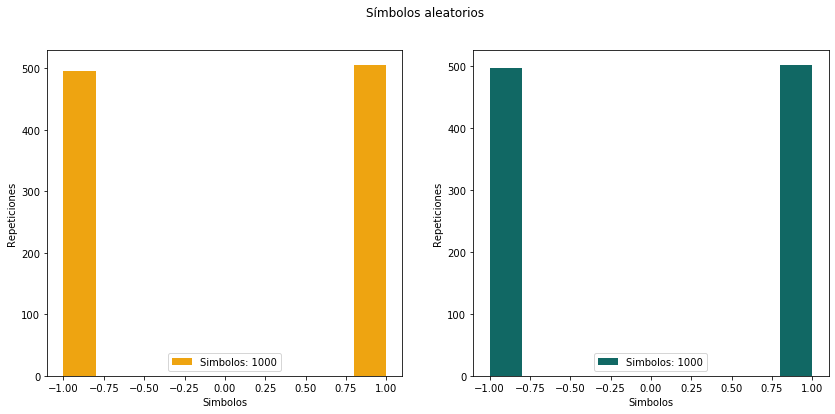

In [10]:
plt.figure(figsize=[14,6])
plt.suptitle("Símbolos aleatorios")
plt.subplot(1,2,1)
plt.hist(akI,label='Simbolos: %d' % Nsymb,color='#EEA411')
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.subplot(1,2,2)
plt.hist(akQ,label='Simbolos: %d' % Nsymb,color='#116864')
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.show()

### 4) Pulse shaping 

In [11]:
(t,h) = rcosine(rolloff,T,N,NB,Norm=False)
#Cuantizo 
Fp = arrayFixedInt(8,7, h,'S', 
    roundMode='round', saturateMode='saturate')
hFp = [FixedPintValue.fValue for FixedPintValue in Fp]


* Respuesta en frecuencia de filtro **cuantizado** 

Text(0, 0.5, 'Amplitud')

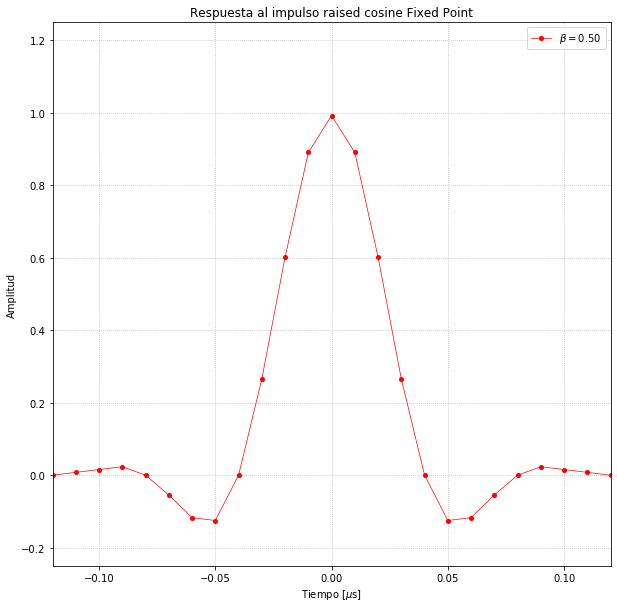

In [12]:
us = 1e6
plt.figure(figsize = [10,10])
plt.grid(linestyle=':', linewidth=0.75)
plt.plot(t*us,hFp,'r-o',linewidth = 0.7,
         markersize=4,label=r'$\beta=%2.2f$'%rolloff)

plt.title ('Respuesta al impulso raised cosine Fixed Point')
plt.legend()
plt.xlim(t[0]*us,t[-1]*us)
plt.ylim(-0.25,1.25)
plt.xlabel('Tiempo [$\mu$s]')
plt.ylabel('Amplitud')

* Respuesta en frecuencia 

In [13]:
NFTT = 1024 
[H,A,F] = resp_freq(hFp, Ts, NFTT)
H_dB = 20*np.log10(H)- 20*np.log10(H[0])

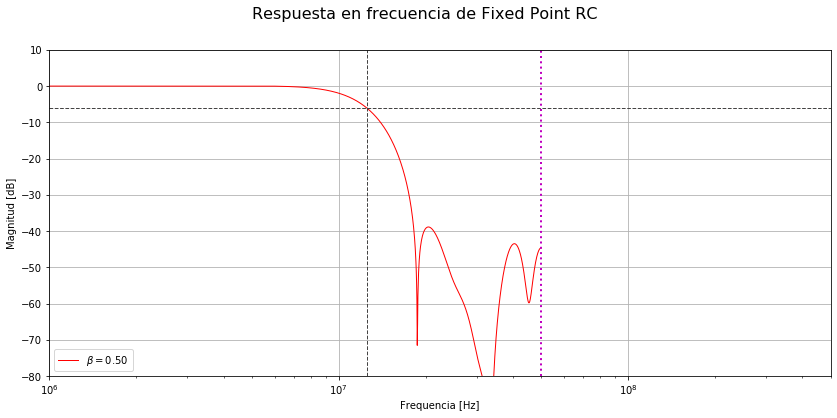

In [14]:
fig=plt.figure(figsize=[14,6])
fig.suptitle('Respuesta en frecuencia de Fixed Point RC ', fontsize=16)

plt.semilogx(F,H_dB ,'r', lw=1.0, label=r'$\beta=%2.2f$'%rolloff)

plt.axvline(x=(1./Ts)/2.,color='m',linewidth=2.0,
           linestyle=":")
plt.axvline(x=(1./T)/2.,color='#454444',
            linewidth=1,linestyle="--") 
plt.axhline(y=20*np.log10(0.5),color='#454444',
            linewidth=1,linestyle="--")

plt.legend(loc=3)
plt.grid(True)
plt.xlim(10e5,F[-1]*10)
plt.ylim(-80,10)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

* Realizamos la convolución tratando de simular la implementación en hardware

![FIR filter](./imgs/FIRFilter.png)

En vez de implementar el filtro de la figura se puede aplicar una **transformación polifásica**, dividir la señal en las 4 fases (N=4) y así lograr un hardware de 4 veces menor longitud y así más simple de implementar. 

La longitud de cada filtro será N x NBaudiosRC / N 

#### Implemetanción filtro con transformación polifásica

In [15]:
lFilt = int( (len(h)-1) / N)             #Longitu de Filtro por fase 
txSymbI = 

* Graficamos la señal s(t) 